<a href="https://colab.research.google.com/github/moshemm/NN-methods-hse/blob/main/CNN-HW2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I. CNN на уровне слов: модель берет слова, пропускает их через Embedding слой. По эмбеддингам проходит CNN c фильтрами с разным окном, полученные результаты конкатенируются друг с другом по глубине, по результату конкатенации еще один сверточный слой, далее max pooling over time, на выходе линейный слой + сигмоида, функция потерь BCELoss. 

## Импорты и загрузка датасета

In [1]:
!pip install torchmetrics -q

     |████████████████████████████████| 418 kB 22.8 MB/s 


In [2]:
!pip install ipdb -q

     |████████████████████████████████| 793 kB 51.3 MB/s 
     |████████████████████████████████| 381 kB 64.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import re
from nltk.tokenize import TweetTokenizer
import tqdm


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1Score as F1
from torchmetrics.functional import f1_score as f1
from torchmetrics.functional import recall
import ipdb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2022-06-06 15:44:37--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2022-06-06 15:44:37--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3467ef7d3f6bdbe547cd06b43d.dl.dropboxusercontent.com/cd/0/inline/Bmtk4fBQj9aBvPWjYncdH_Q2TYUrRlscEZGs27HExtPRGpXrNeZjJlhb4qMlGxXtoScuDqDHWjPqBqxy9ZbZ9pXDDTTcS7a1TVkMLneEUKRehCY92AhfZxlP23IrsUKDLWqJVLCycODCxMoCRwgSUWi1pTODDSjVmVbzrr-5USq_Zw/file# [following]
--2022-06-06 15:44:37--  https://uc3467ef7d3f6bdbe547cd06b43d.dl.dropboxusercontent.com/cd/0/inline/Bmtk4fBQj9aBvPWjYncdH_Q2TYUrRlscEZGs27HExtPRGpXrNeZjJlhb4qMlGxXtoScu

## Пандас. Объединяем датасеты, 

In [5]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], header=None, names=['text'])
positive.head()

,text
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...


In [6]:
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], header=None, names=['text'])
negative.head()

,text
0,на работе был полный пиддес :| и так каждое за...
1,"Коллеги сидят рубятся в Urban terror, а я из-з..."
2,@elina_4post как говорят обещаного три года жд...
3,"Желаю хорошего полёта и удачной посадки,я буду..."
4,"Обновил за каким-то лешим surf, теперь не рабо..."


In [7]:
positive['label'] = 1
positive.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [8]:
negative['label'] = 0

In [9]:
frames = [positive, negative]
data = pd.concat(frames)
data.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,0
111919,скучаю так :-( только @taaannyaaa вправляет мо...,0
111920,"Вот и в школу, в говно это идти уже надо(",0
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0
111922,Такси везет меня на работу. Раздумываю приплат...,0


In [10]:
data.shape

(226834, 2)

In [11]:
data.reset_index(drop=True, inplace=True)
data.tail()

,text,label
226829,Но не каждый хочет что то исправлять:( http://...,0
226830,скучаю так :-( только @taaannyaaa вправляет мо...,0
226831,"Вот и в школу, в говно это идти уже надо(",0
226832,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0
226833,Такси везет меня на работу. Раздумываю приплат...,0


In [12]:
pd.set_option('display.max_colwidth', None)

In [13]:
data.sample(50)

,text,label
75101,Вот такой фасад школы получился) http://t.co/mo7RD4A4Wx,1
181084,"Работать хорошо и без эпикфейлов? Не, не слышал. :( #котэ",0
134952,Проиграли 1:2 Ак Барсу :( Вот такая пятница 13..,0
208235,какой-то не здоровый #туман в городе!( #Барнаул,0
219287,"давно я в пробке не стояла, на экзамен бы не опоздать:(",0
41418,причём это на паре)))) ээто норма☺ #пара #конституционноеправо #учёба,1
55705,RT @Eblya69: @ThomasPorn1 @Vika_Winchester эхэхэ это шедеврально :D,1
121632,"Глупею на глазах :( Внутренние фильтры, ограничивающие глупость, отказывают.",0
31322,"Наивный соседи) думают что у меня звук , ударами по батарее убавляется))) http://t.co/8kiIsgrN5l",1
91416,"RT @SamatIsaev: Думаю вне зависимости от возраста, каждый из нас ждёт чуда в новогоднюю ночь...заложено с детства)))",1


In [14]:
def preprocess(text):
  text = re.sub('https?:\S+', ' ', text) # убрать urls
  text = re.sub('@\S+', ' ', text) # убрать никнеймы
  text = TweetTokenizer().tokenize(text)
  return text

In [15]:
data['text'] = data['text'].apply(preprocess)
data.sample(10)

,text,label
22975,"[Данюш, у, меня, завтра, днюха, .., добавишь, хоть, ?, ), пожалууйста, ), ), )]",1
69297,"[RT, Странно, -, с, ходу, вспоминаю, еще, двух, Миш-девочек, ., А, как, у, них, полное, имя, ?, Михаила, ?, ), ), Мишанна, ?, )]",1
24615,"[все, ,, теперь, я, могу, смело, сказать, :, "", Я, свободен, !, "", ..., или, спеть, :)]",1
85558,"[ахах, :), ), ох, да, ,, ну, у, мальчиков, зато, нет, такой, логики, :), )]",1
137934,"[Два, сеошника, общаются, по, скайпу, ,, один, другому, :, -, Сижу, злой, и, голодный, ,, микроволновка, сломалась, (, (, (, -, И, что, пишет, ?]",0
224435,"[:(, А, ВСЁ, ЭТА, ЧЕРТОВА, Ш, К, О, Л, А, ЫЫЫ]",0
131183,"[первым, не, выдержал, Вася, Шандыбин, ;(, (, (, где, Вася, ?, (, (, (, нету, Васи, (, (, (, убили, Василия, (, (, (]",0
122957,"[День, тупой, !, нет, настроение, и, по, здоровью, хреного, (]",0
215003,"[я, идиот, последний, иду, же, ., От, волнения, всю, очередь, прлпустила, ., Скоро, пойду, :(, там, говорят, не, реально, сдать]",0
159442,"[Освободив, МБХ, он, тут, же, посадил, на, 3, года, эколога, за, надпись, на, заборе, Ткачева, и, доклад, об, олимп, ., нарушениях, ., Балланс, восстановлен, (]",0


In [16]:
train_data, notrain_data = train_test_split(data, test_size=0.2)
val_data, test_data = train_test_split(data, test_size=0.5)
print(train_data.shape, val_data.shape, test_data.shape)

(181467, 2) (113417, 2) (113417, 2)


In [17]:
print(train_data['label'].value_counts())
print(val_data['label'].value_counts())
print(test_data['label'].value_counts())

1    91786
0    89681
Name: label, dtype: int64
1    57585
0    55832
Name: label, dtype: int64
1    57326
0    56091
Name: label, dtype: int64


In [18]:
train_data.sample(10)

,text,label
210195,"[Еле, проснулся, ,, а, обещал, себе, встать, в, 9, ., :(]",0
59736,"[ага, ,, я, про, твиттер, ), однако, количество, откликов, тесно, коррелирует, с, ответами, на, предыдущие, отклики, )]",1
54727,"[пора, начинать, ,, уже, взрослая, девочка, :)]",1
1568,"[gozunuz, aydinnnn, ), ), ), Баку, вошел, в, список, самых, дорогих, городов, мира, –, ФОТО, -, 1NEWS.AZ]",1
161345,"[бля, ,, я, пожалела, брата, и, пошла, с, ним, искать, карточку, и, наша, (, (, (, кина, не, будет]",0
104672,"[А, то, если, честно, впечатлило, моё, нежданное, знакомство, ), Так, впечатлило, ,, что, не, знаю, даже, что, и, сказать, )]",1
37630,"[что, достается, в, айтишной, семье, после, койки, ?, правильно, ,, сервер, :)]",1
152051,"[каждый, день, добиваю, ,, ему, не, нравится, это, :(]",0
175655,"[спорт, еще, сложнее, ,, чем, меньше, жрать, :(]",0
115048,"[Мало, того, что, я, потеряла, из-за, него, сережки, ,, он, их, так, и, не, нашел, !, !, !, :(, (]",0


In [19]:
vocab = Counter()

for row in train_data.text:
  for tok in row:
    vocab[tok] += 1

print(f'Уникальных слов: {len(vocab)}')

Уникальных слов: 197200


In [20]:
vocab.most_common(20)

[(',', 149759),
 (')', 112690),
 ('(', 103117),
 ('не', 55653),
 ('.', 54806),
 ('!', 48711),
 ('и', 44249),
 ('я', 42487),
 ('в', 42226),
 (':(', 30322),
 ('RT', 29907),
 ('на', 28703),
 ('?', 27965),
 ('что', 25399),
 ('...', 21907),
 ('с', 21881),
 ('а', 21647),
 ('"', 18958),
 (':)', 18406),
 ('меня', 16677)]

In [21]:
filtered_vocab = set()

for word in vocab:
  if vocab[word] >= 3:
    filtered_vocab.add(word)

print(f'Слова встретились 3 и больше раз: {len(filtered_vocab)}')

Слова встретились 3 и больше раз: 49940


In [22]:
word2id = {'PAD': 0,
           'UNK': 1}

for word in filtered_vocab:
  word2id[word] = len(word2id)

In [23]:
id2word = {idx:word for word, idx in word2id.items()}

In [24]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

## Dataset и DataLoader

Определим, до какой длинны будем паддить

In [25]:
np.percentile(data['text'].apply(len), 97)

29.0

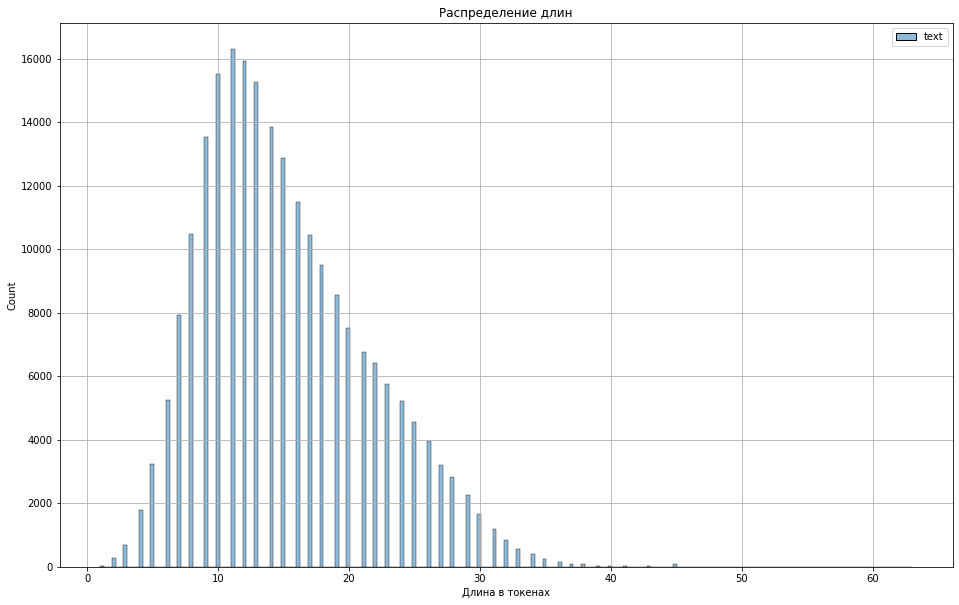

In [26]:
lengths = [data['text'].apply(len)]


plt.figure(figsize=(16, 10))
plt.grid()
plt.title("Распределение длин")
plt.xlabel("Длина в токенах")
sns.histplot(lengths);

Определим Dataset

In [27]:
class SentDataset(Dataset):
  def __init__(self, x, y, word2id, DEVICE, pad=0, max_len=30):

    super().__init__()

    self.x = x
    self.y = y

    self.word2id = word2id
    self.pad = pad
    self.max_len = max_len
    self.device = DEVICE


  def __len__(self):
    return len(self.x)


  def indexing(self, text):
    text_ids = [word2id[tok] if tok in word2id else word2id['UNK'] for tok in text]
    return text_ids

  def padding(self, text):
    text = text[:self.max_len]
    text = F.pad(text, (0, self.max_len - len(text)))

    return text


  def __getitem__(self, idx):

    text = self.x.iloc[idx]
    text = self.indexing(text)

    text = torch.tensor(text).to(self.device)
    target = torch.Tensor([self.y.iloc[idx]]).to(self.device) # нам нужен float, а не int

    text = self.padding(text)

    return(text, target)
  


In [28]:
train_dataset = SentDataset(x=train_data['text'], y=train_data['label'], word2id=word2id, DEVICE=DEVICE)

In [29]:
# Проверочка
x, y = train_dataset[5]
print(x, x.shape)
print(y, y.shape)

tensor([ 9041, 14605,  7560, 19643, 19285,     1, 15866, 15379,     1, 46032,
            1,  5415, 20356, 22956,     1, 11159, 40885,  5415, 31161, 11326,
          507,    91,  6999,  6999,     0,     0,     0,     0,     0,     0],
       device='cuda:0') torch.Size([30])
tensor([0.], device='cuda:0') torch.Size([1])


In [30]:
train_loader = DataLoader(train_dataset, batch_size=128)

In [31]:
batch = next(iter(train_loader))[0]
print(batch, f'\nBatch size: {batch.shape}')

tensor([[42216, 15866, 38734,  ...,     0,     0,     0],
        [ 2511,  7257,  1121,  ...,     0,     0,     0],
        [49479, 49479, 15866,  ...,     0,     0,     0],
        ...,
        [ 4353, 44591,     1,  ...,     0,     0,     0],
        [32506, 11085,  2299,  ...,     0,     0,     0],
        [45837,  3123, 25076,  ...,     0,     0,     0]], device='cuda:0') 
Batch size: torch.Size([128, 30])


In [32]:
val_dataset = SentDataset(x=val_data['text'], y=val_data['label'], word2id=word2id, DEVICE=DEVICE)
val_loader = DataLoader(val_dataset, batch_size=128)
print(next(iter(val_loader))[0].shape)

test_dataset = SentDataset(x=test_data['text'], y=test_data['label'], word2id=word2id, DEVICE=DEVICE)
test_loader = DataLoader(test_dataset, batch_size=128)
print(next(iter(test_loader))[0].shape)



torch.Size([128, 30])
torch.Size([128, 30])


## CNN Model

In [33]:
class CNN(nn.Module):
  def __init__(self, vocab_size, emb_dim):

    super().__init__()

    self.embedding = nn.Embedding(vocab_size, emb_dim) # логично emb_dim делать размером корень из vocab_size
    self.bigram = nn.Conv1d(in_channels=emb_dim, out_channels=50, kernel_size=2, padding='same') # out_channels - кол-во разных фильтров
    self.trigram = nn.Conv1d(in_channels=emb_dim, out_channels=50, kernel_size=3, padding='same')
    self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, padding='same')
    self.linear = nn.Linear(in_features=100, out_features=1)
    self.relu = nn.ReLU()
    self.sigm = nn.Sigmoid()

  def forward(self, sent):
    # batch_size x seq_len
    embedded = self.embedding(sent) # -> batch_size x seq_len x emb_dim
    # Conv1d берет на вход (batch_size, in_channels, seq_len) - 
    # надо транспонировать (менять 1 и 2 размерность местами)
    embedded = embedded.transpose(1, 2)

    # первый слой со свертками
    feature_map_bigram = self.pooling(self.relu(self.bigram(embedded))) # -> batch_size x filter_out_channel x seq_len (padding?)
    feature_map_trigram = self.pooling(self.relu(self.trigram(embedded)))

    concat = torch.concat((feature_map_bigram, feature_map_trigram), 1)

    feature_map_final = self.relu(self.conv2(concat))

    # Хотим избавиться от seq_len - max pooling over time
    pool = feature_map_final.max(2)[0] # -> batch_size x filter_out_channel

    hidden = self.linear(pool)
    out = self.sigm(hidden)

    return out



  

Попробуем пропустить один батч через модель - должны получит ьвероятности для каждого элемента батча (batch_size=16) 

In [34]:
batch, y = next(iter(train_loader))
batch, y = batch.to(DEVICE), y.to(DEVICE)
print(batch, y)
print(batch.shape, y.shape)

tensor([[42216, 15866, 38734,  ...,     0,     0,     0],
        [ 2511,  7257,  1121,  ...,     0,     0,     0],
        [49479, 49479, 15866,  ...,     0,     0,     0],
        ...,
        [ 4353, 44591,     1,  ...,     0,     0,     0],
        [32506, 11085,  2299,  ...,     0,     0,     0],
        [45837,  3123, 25076,  ...,     0,     0,     0]], device='cuda:0') tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
     

In [35]:
model = CNN(len(word2id), 256)
model = model.to(DEVICE)
output = model(batch)
print(output)

tensor([[0.5105],
        [0.5216],
        [0.4993],
        [0.5076],
        [0.5180],
        [0.5028],
        [0.4998],
        [0.5173],
        [0.5078],
        [0.5104],
        [0.5137],
        [0.5274],
        [0.5101],
        [0.5455],
        [0.5225],
        [0.4979],
        [0.5174],
        [0.5107],
        [0.5571],
        [0.5127],
        [0.5115],
        [0.5125],
        [0.5160],
        [0.4992],
        [0.5170],
        [0.5212],
        [0.5058],
        [0.5576],
        [0.5095],
        [0.5306],
        [0.5000],
        [0.4890],
        [0.5168],
        [0.5274],
        [0.4922],
        [0.5423],
        [0.5208],
        [0.5326],
        [0.5263],
        [0.4953],
        [0.5141],
        [0.5212],
        [0.4852],
        [0.5149],
        [0.4999],
        [0.4778],
        [0.5037],
        [0.5221],
        [0.5173],
        [0.5182],
        [0.5023],
        [0.5440],
        [0.5255],
        [0.5133],
        [0.5095],
        [0

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:299: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


In [36]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.6970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [37]:
f1(output, y.long()) # The `target` has to be an integer tensor.

tensor(0.6061, device='cuda:0')

# Train & eval loops

In [38]:
model = CNN(len(word2id), 256)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()  

# веса модели и значения лосса храним в одном месте
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [39]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = []
  epoch_f1 = []
  
  print('Training...')
  model.train()

  for i, (text, y) in enumerate(iterator):
    optimizer.zero_grad()
    pred = model(text)
    loss = criterion(pred, y)
    loss.backward()

    optimizer.step()
    epoch_loss.append(loss.item()) # item() converts its value to a standard Python number (to CPU)

    batch_f1 = f1(pred.round().long(), y.long(), ignore_index=0)
    epoch_f1.append(batch_f1.item())

    
  return sum(epoch_loss) / len(iterator), sum(epoch_f1) / len(iterator), epoch_loss, epoch_f1

In [40]:
def evaluate(model, iterator, optimizer, criterion):
  epoch_loss = []
  epoch_f1 = []
  
  print('Evaluating...')
  model.eval()
  with torch.no_grad():
    for i, (text, y) in enumerate(iterator):
      pred = model(text)
      loss = criterion(pred, y)
      epoch_loss.append(loss.item()) # item() converts its value to a standard Python number (to CPU)

      batch_f1 = f1(pred.round().long(), y.long(), ignore_index=0)
      epoch_f1.append(batch_f1.item())
      
    return sum(epoch_loss) / len(iterator), sum(epoch_f1) / len(iterator), epoch_loss, epoch_f1



In [41]:
# Start

losses = []
f1s = []
eval_losses = []
eval_f1s = []

for epoch in tqdm.tqdm(range(1)):

    print(f'\nEpoch {epoch + 1}')
    epoch_loss, epoch_f1, batch_loss, batch_f1 = train(model, train_loader, optimizer, criterion)
    losses.append(epoch_loss)
    f1s.append(epoch_f1)
    print(f'Train loss: {epoch_loss}, Train_f1: {epoch_f1}')
    print('. . . ' * 5)
    epoch_val_loss, epoch_val_f1, val_batch_loss, val_batch_f1 = evaluate(model, val_loader, optimizer, criterion)
    eval_losses.append(epoch_val_loss)
    eval_f1s.append(epoch_val_f1)
    print(f'\n\nEval loss: {epoch_val_loss}, eval_f1: {epoch_val_f1}')
    print('. . . ' * 5)

  0%|          | 0/1 [00:00<?, ?it/s]


Epoch 1
Training...
Train loss: 0.02270032107363042, Train_f1: 0.9918524288744449
. . . . . . . . . . . . . . . 
Evaluating...


100%|██████████| 1/1 [00:54<00:00, 54.06s/it]



Eval loss: 0.005336713232147587, eval_f1: 0.9979411900513874
. . . . . . . . . . . . . . . 


In [42]:
def plot_training(train_loss, train_metric, val_loss, val_metric):
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(train_loss, label='loss')
    axs[0].plot(train_metric, label='f1')
    axs[0].set_xlabel('Iterations')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid()
    axs[0].set_title('Train')

    axs[1].plot(val_loss, label='loss')
    axs[1].plot(val_metric, label='f1')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid()
    axs[1].set_title('Val')

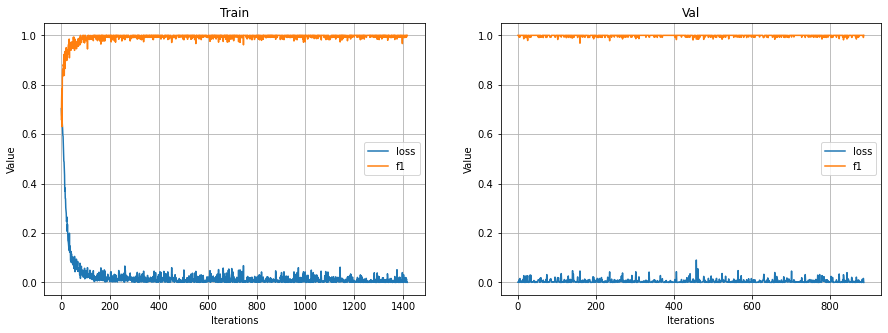

In [45]:
plot_training(batch_loss, batch_f1, val_batch_loss, val_batch_f1)

Кажется, эта модель слишком сложная для датасета (а датасет - слишклм простой). Этот же датасет легко решался логистической регрессией. Все благодаря токену ")", который в большом кол-ве встречается в положительных отзывах. Поэтому если не удалять пунктуацию, очень быстро добиваемся высоких результатов!

Посчитаем долю позитивных текстов с символом ')'

In [57]:
len(positive[positive['text'].str.contains('\)')])/len(positive)

0.8289632846289737

А в негативных такого смайла мы не встретим. Даже если мы основывали нашу бинарную классификацию только на этом символе, наше качество было бы почти 83%

In [58]:
len(negative[negative['text'].str.contains('\)')])/len(negative)

0.0